In [1]:
import shutil
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import numpy as np
from tqdm import tqdm
from lib import kscc
from lib import kscc_metrics
import warnings
import csv

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

%matplotlib inline

# 0) Constants & methods

In [2]:
# maximum number of clusters and seed for algorithm initialization 
KMAX = 10
K_INIT = 3
RNDN = 42
N_INIT = 100
INSCRITOS_PATH = os.path.join("datasets", "cat_dataset_saber11_inscripciones_fcen_20171_20192.csv")
colors = ['#55CBCD', '#F3B0C3', '#CCE2CB', '#ABDEE6', '#FFCCB6', 
          '#FFFFB5', '#CBAACB', '#C6DBDA', '#FF968A', '#FEE1E8', 
          '#FFDBCC', '#ECEAE4', '#A2E1DB', '#97C1A9', '#FFC8A2', 
          '#ECD5E3' 
         ]

In [3]:
def clusterPies_centroids(df_centroids, df_data, attributes, n_cols=4, figsize=(25, 10), bbox_loc=(-0.25, 1.), cat_fontsize=10, sup_fontsize='xx-large', pie_fontsize=30):
    # number of attributes
    att_len = len(attributes)

    # max number of columns in subplotting
    n_cols = n_cols
    n_rows = int(np.ceil(att_len/n_cols))

    # number of clusters
    K = df_centroids.shape[1]

    for n_cluster, k in enumerate(list(df_centroids.columns)):
        dfc = df_data[df_data["cluster"]==n_cluster]
        cases = dfc.shape[0]
                
        fig = plt.figure(figsize=figsize)
        fig.suptitle( k + ": " + \
            f'{cases:,.0f}' + " casos", fontsize=sup_fontsize)
        
        # Transparent background
        fig = plt.gcf()
        fig.patch.set_alpha(0)

        row_indices = completeRowIndices(n_rows-1, n_cols) + [n_rows-1]*(att_len-n_cols*(n_rows-1))
        col_indices = list(range(n_cols))*(n_rows-1) + list(range(att_len-n_cols*(n_rows-1)))
        atts_and_pos = list(zip(row_indices, col_indices, attributes))
        for row, col, att in atts_and_pos:
            ax1 = plt.subplot2grid((n_rows, n_cols),(row, col))
            dict_sorted = dict(sorted(df_centroids[k][att].items(), key=lambda item: item[1], reverse=True))
            y = np.array(list(dict_sorted.values()))
            x = list(dict_sorted.keys())
            patches, texts = plt.pie(y, 
                                     wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, 
                                     colors=colors)
            percentages = y*100./y.sum()
            labels = ['{0} - {1:1.2f} %'.format(i[:30],j) for i,j in zip(x, percentages)]
            patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                                  key=lambda x: x[2],
                                                  reverse=True))
            plt.legend(patches, labels, loc='upper center', bbox_to_anchor=bbox_loc,
                       fontsize=cat_fontsize)
            plt.title(att, fontsize=pie_fontsize)

        plt.savefig("{0}/{1}.png".format(output_folder, k), dpi=300)
    

def completeRowIndices(n_rows, n_cols):
    row_indices = []
    for i in range(n_rows):
        for j in range(n_cols):
            row_indices.append(i)
    
    return row_indices        

def load_data(inscritos_path=INSCRITOS_PATH):
    csv_path = os.path.join(inscritos_path)
    return pd.read_csv(csv_path, sep=',')

def makedirs(path):
    if not os.path.exists(path):
        os.makedirs(path)
    else:
        shutil.rmtree(path)  # Removes all the subdirectories!
        os.makedirs(path)

def plot_save_silhouette_diagram(n_clusters, len_x, sample_silhouette_values, silhouette_avg, output_folder):
    # Create a subplot with 1 row and 2 columns
    fig1, ax1 = plt.subplots()
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len_x + (n_clusters + 1) * 10])
    
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Cluster")
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle((r"#clusters = %d, $s_{%d}$ = %.3f" % (n_clusters, n_clusters, silhouette_avg)),
                 fontsize=13)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors[i]
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, 
                          edgecolor=color
                         )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.savefig("{0}/kscc_it_k={1}.png".format(output_folder, n_clusters), dpi=300)


def save_silhouette_averages(results, output_folder, ofile):
    with open("{0}/{1}".format(output_folder,ofile), 'w') as fp:
        out = csv.writer(fp)
        out.writerows(map(lambda x: [x], results))
   

# 1) k-SCC clustering

## 1.1) Data reading

In [4]:
df = load_data() 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4011 entries, 0 to 4010
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   fami_tienecomputador    4011 non-null   object
 1   fami_tieneautomovil     4011 non-null   object
 2   fami_educacionmadre     4011 non-null   object
 3   fami_trabajolabormadre  4011 non-null   object
 4   fami_estratovivienda    4011 non-null   object
 5   cole_naturaleza         4011 non-null   object
 6   cole_jornada            4011 non-null   object
 7   punt_global_cuartil     4011 non-null   object
 8   nlprog_mod              4011 non-null   object
 9   admitido                4011 non-null   object
dtypes: object(10)
memory usage: 313.5+ KB


In [6]:
carrera = "ASTRONOMÍA"
condicion = df["nlprog_mod"] == carrera
df_carrera = df[condicion].drop(columns=["nlprog_mod"])

In [7]:
df_carrera.info()

<class 'pandas.core.frame.DataFrame'>
Index: 659 entries, 2467 to 3125
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   fami_tienecomputador    659 non-null    object
 1   fami_tieneautomovil     659 non-null    object
 2   fami_educacionmadre     659 non-null    object
 3   fami_trabajolabormadre  659 non-null    object
 4   fami_estratovivienda    659 non-null    object
 5   cole_naturaleza         659 non-null    object
 6   cole_jornada            659 non-null    object
 7   punt_global_cuartil     659 non-null    object
 8   admitido                659 non-null    object
dtypes: object(9)
memory usage: 51.5+ KB


## 1.2) Silhouette scores: determining the optimal number of clusters

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:28<00:00, 18.59s/it]


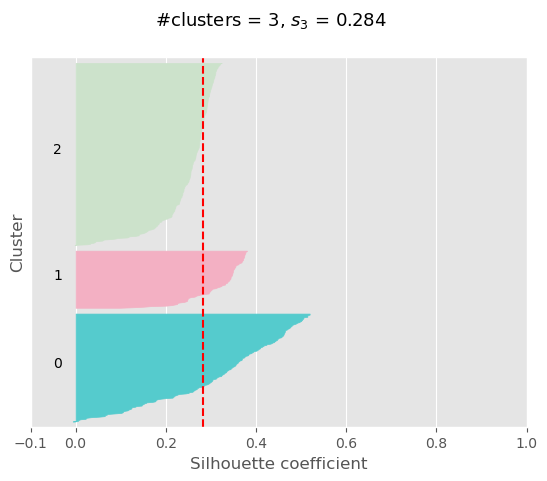

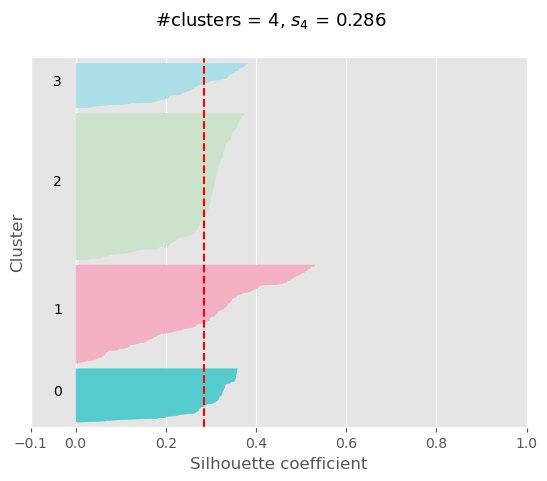

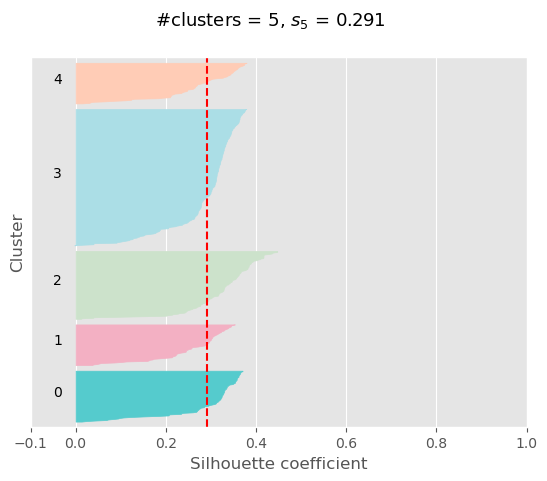

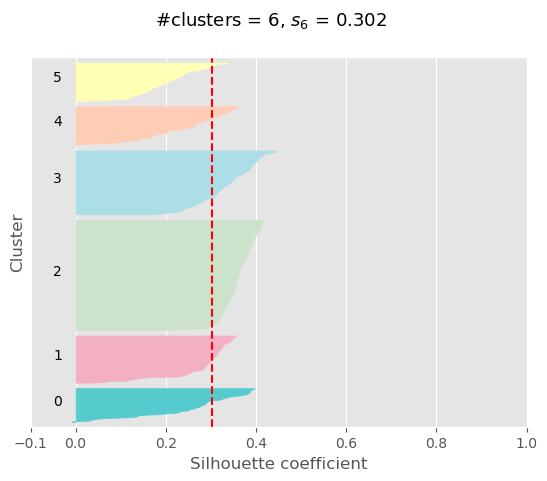

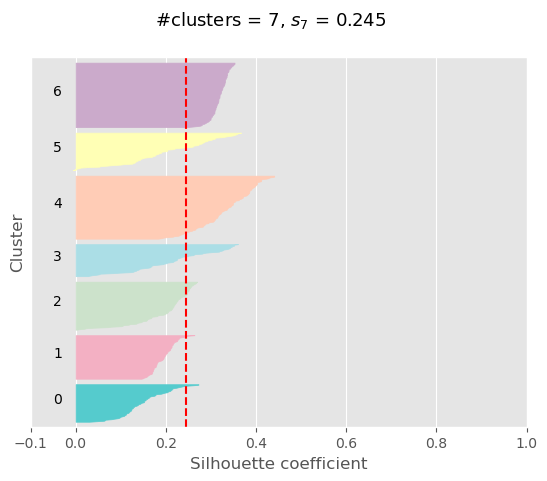

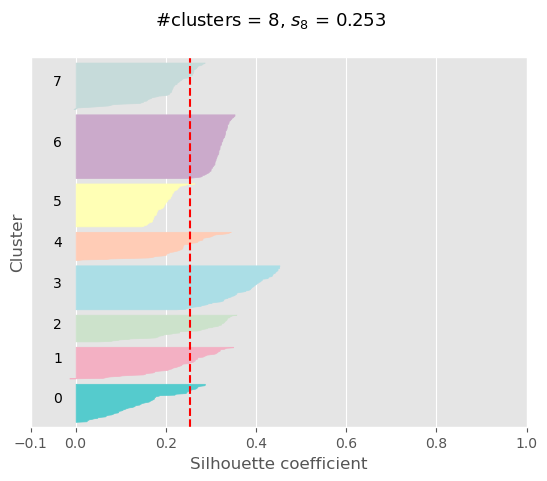

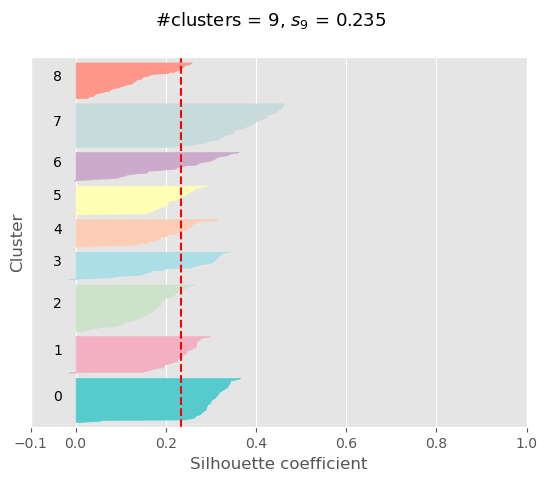

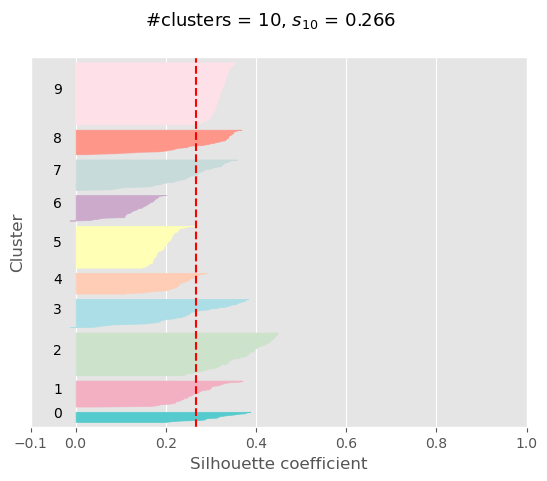

In [8]:
ofile = "kscc_it.csv"
output_folder = "output"
makedirs(output_folder)

"""
MAIN LOOP: the steps of k-SCC are carried out. 
Cluster labels and probabilistic centers are determined 
for each number of clusters k (k in [K_INIT, KMAX]),
after that it is computed all observations silhouette values  
and plotted the silhouette diagram for each k
along with its respective silhouette score,
this with the goal of determining the optimal number of clusters.
"""

x = df_carrera.to_numpy()
cluster_labels_per_k = []
centroids_per_k = []
results_silhouette_avg = []
for n_clusters in tqdm(range(K_INIT, KMAX+1)):
    kscc_object = kscc.KSCC_Kernel_IT(n_clusters=n_clusters, n_init=N_INIT, verbose=0, n_jobs=-1)
    kscc_object.fit_predict(x)
    cluster_labels = kscc_object.labels_
    cluster_labels_per_k.append(cluster_labels)
    centroids_per_k.append(kscc_object.cluster_centroids_)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    _distance = kscc.pairwise_distances(x)
    sample_silhouette_values, silhouette_avg = kscc_metrics.silhouette_score(x, cluster_labels,_distance)
    results_silhouette_avg.append(silhouette_avg)

    # Plot and save each silhouette diagram
    plot_save_silhouette_diagram(n_clusters=n_clusters, 
                                 len_x=len(x), 
                                 sample_silhouette_values=sample_silhouette_values,
                                 silhouette_avg=silhouette_avg, 
                                 output_folder=output_folder)
    
# Save silhouette averages in a csv file
save_silhouette_averages(results=results_silhouette_avg, output_folder=output_folder, ofile=ofile)

## 1.3) Visualization of probabilistic centers

In [9]:
n_clusters = int(input("Ingresa el número de clusters: "))
cols = [col for col in df_carrera.columns if col not in ["cluster"]]
all_cluster_labels = ['Primer Cluster', 'Segundo Cluster', 'Tercer Cluster', 'Cuarto Cluster', 'Quinto Cluster', 
                      'Sexto Cluster', 'Séptimo Cluster', 'Octavo Cluster', 'Noveno Cluster', 'Décimo Cluster']
index = all_cluster_labels[:n_clusters]
# Create the centroids data frame
df_centroids = pd.DataFrame(centroids_per_k[n_clusters-K_INIT], columns = cols, index = index).T

# from defaultdict to dict
for column in df_centroids.columns:
    for row in df_centroids.index:
        df_centroids[column][row] = dict(df_centroids[column][row]) 

Ingresa el número de clusters:  5


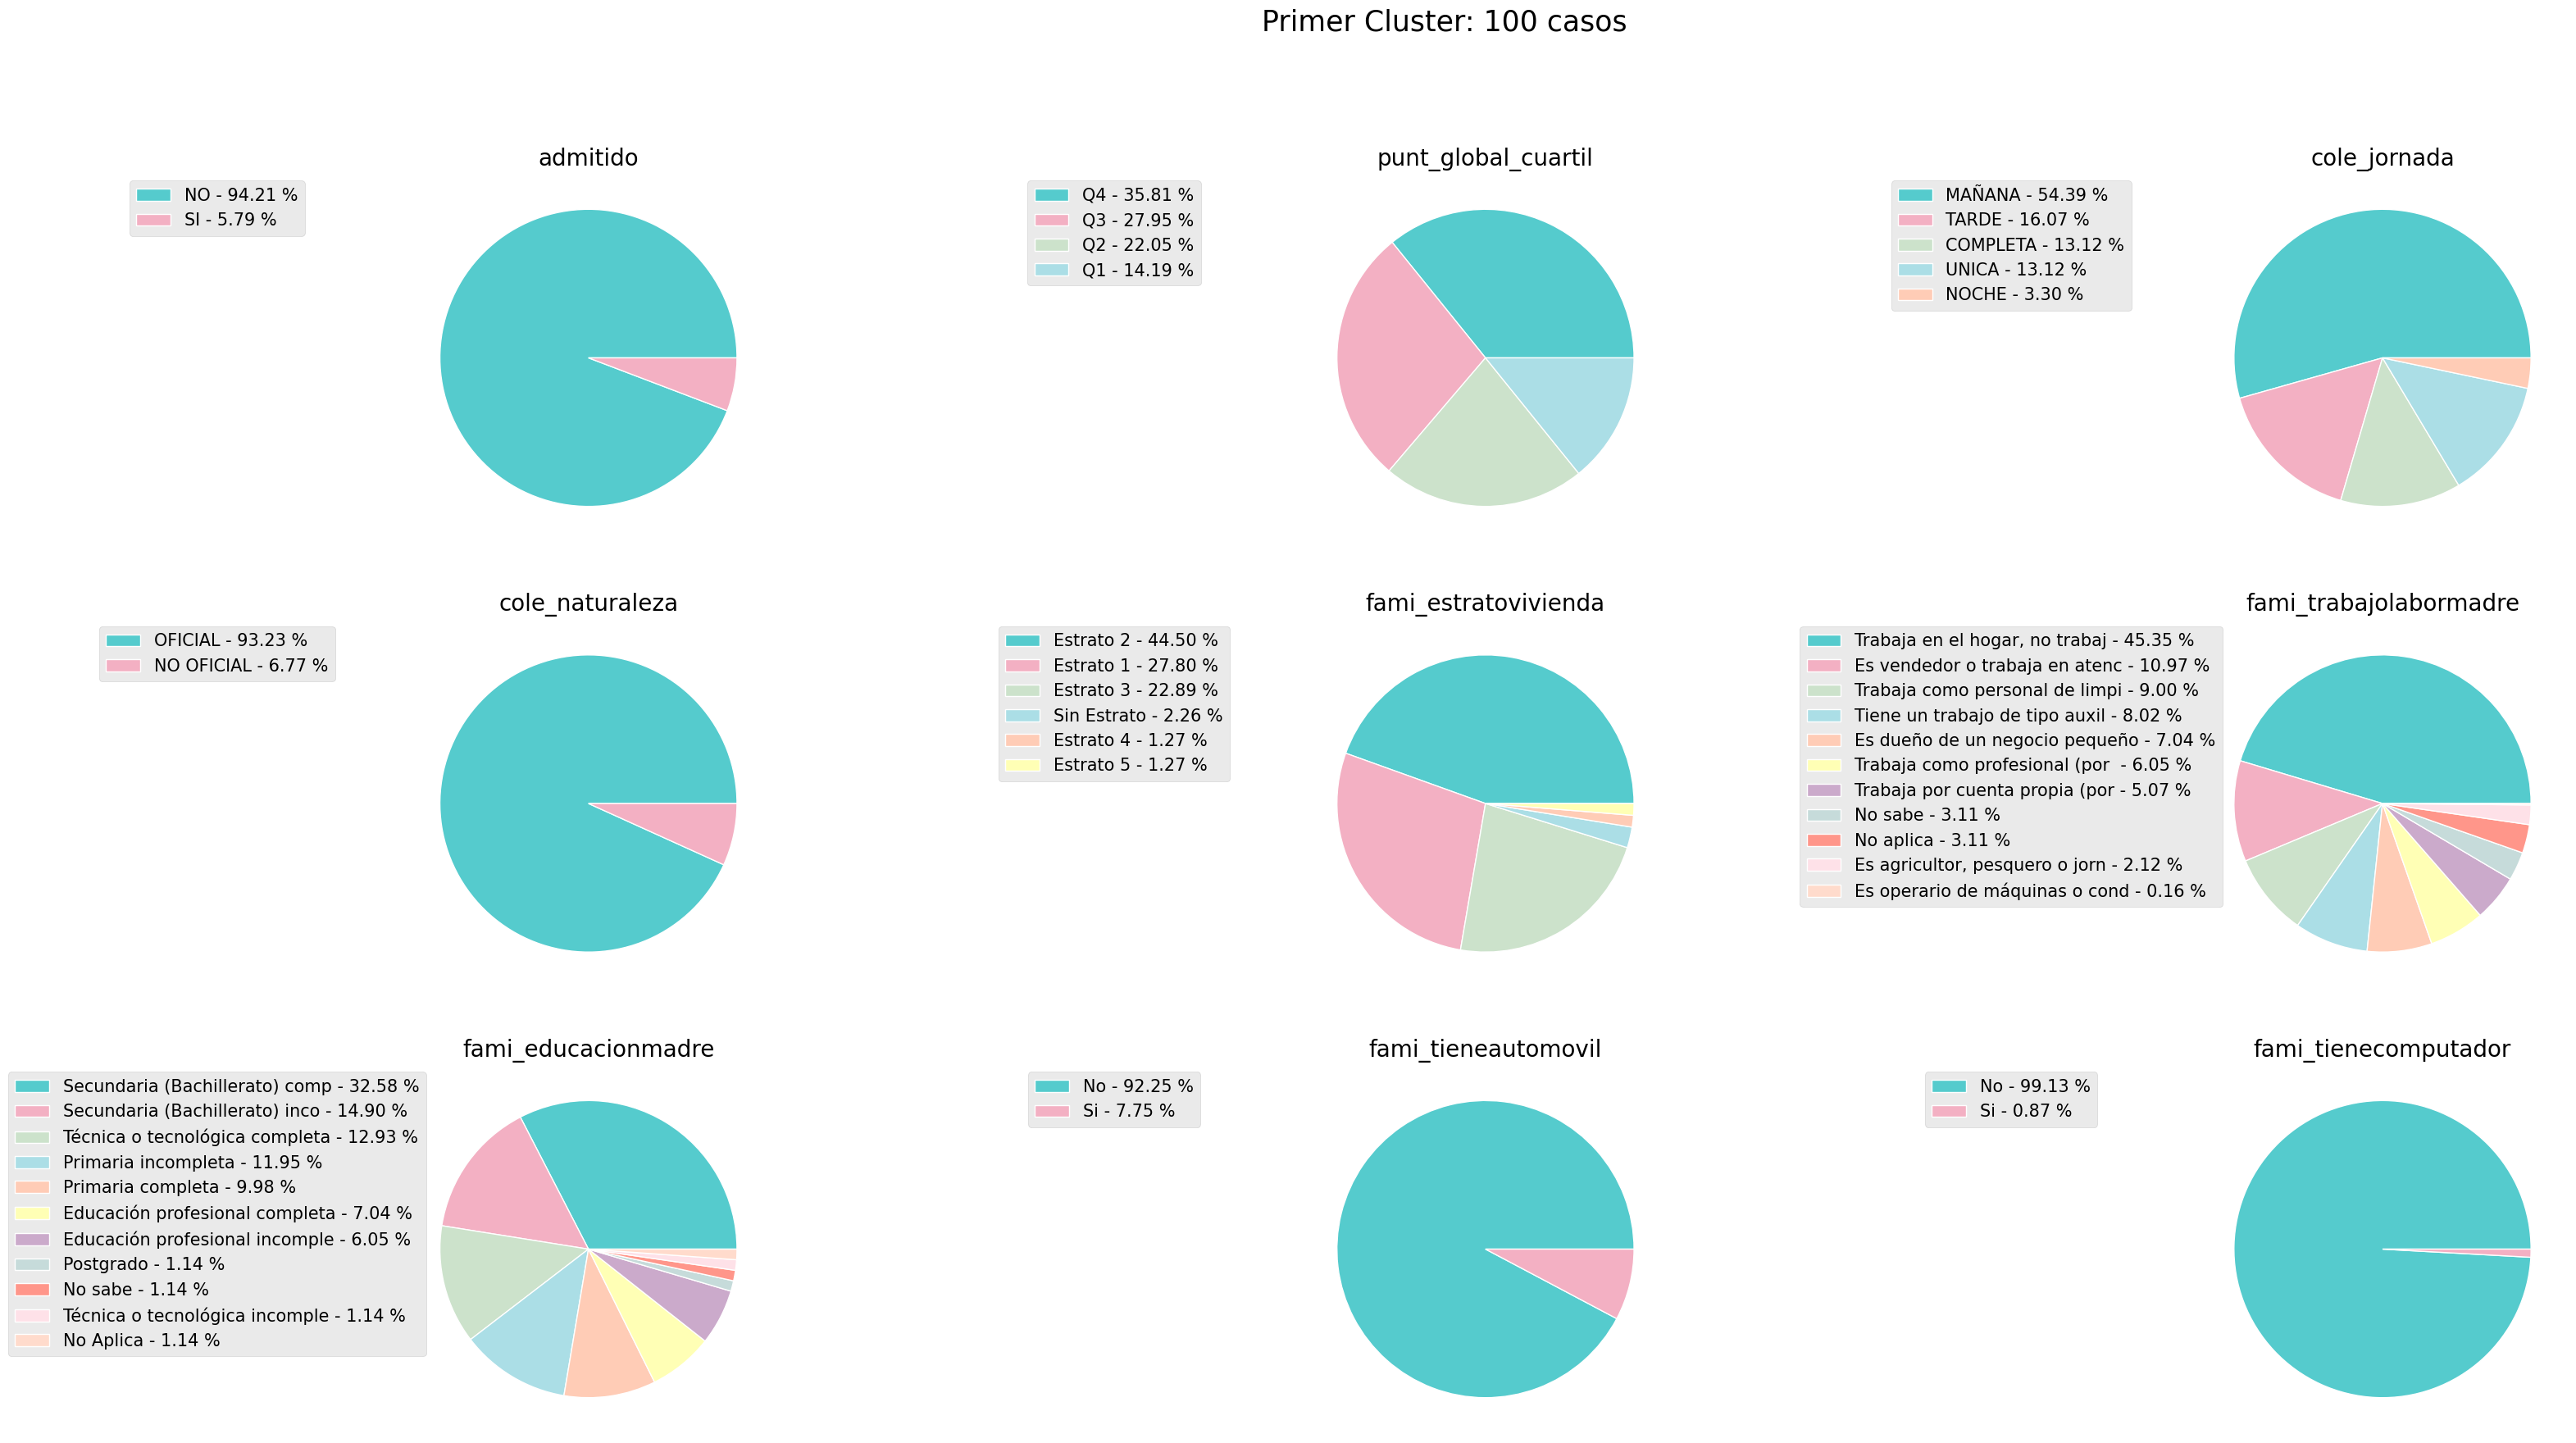

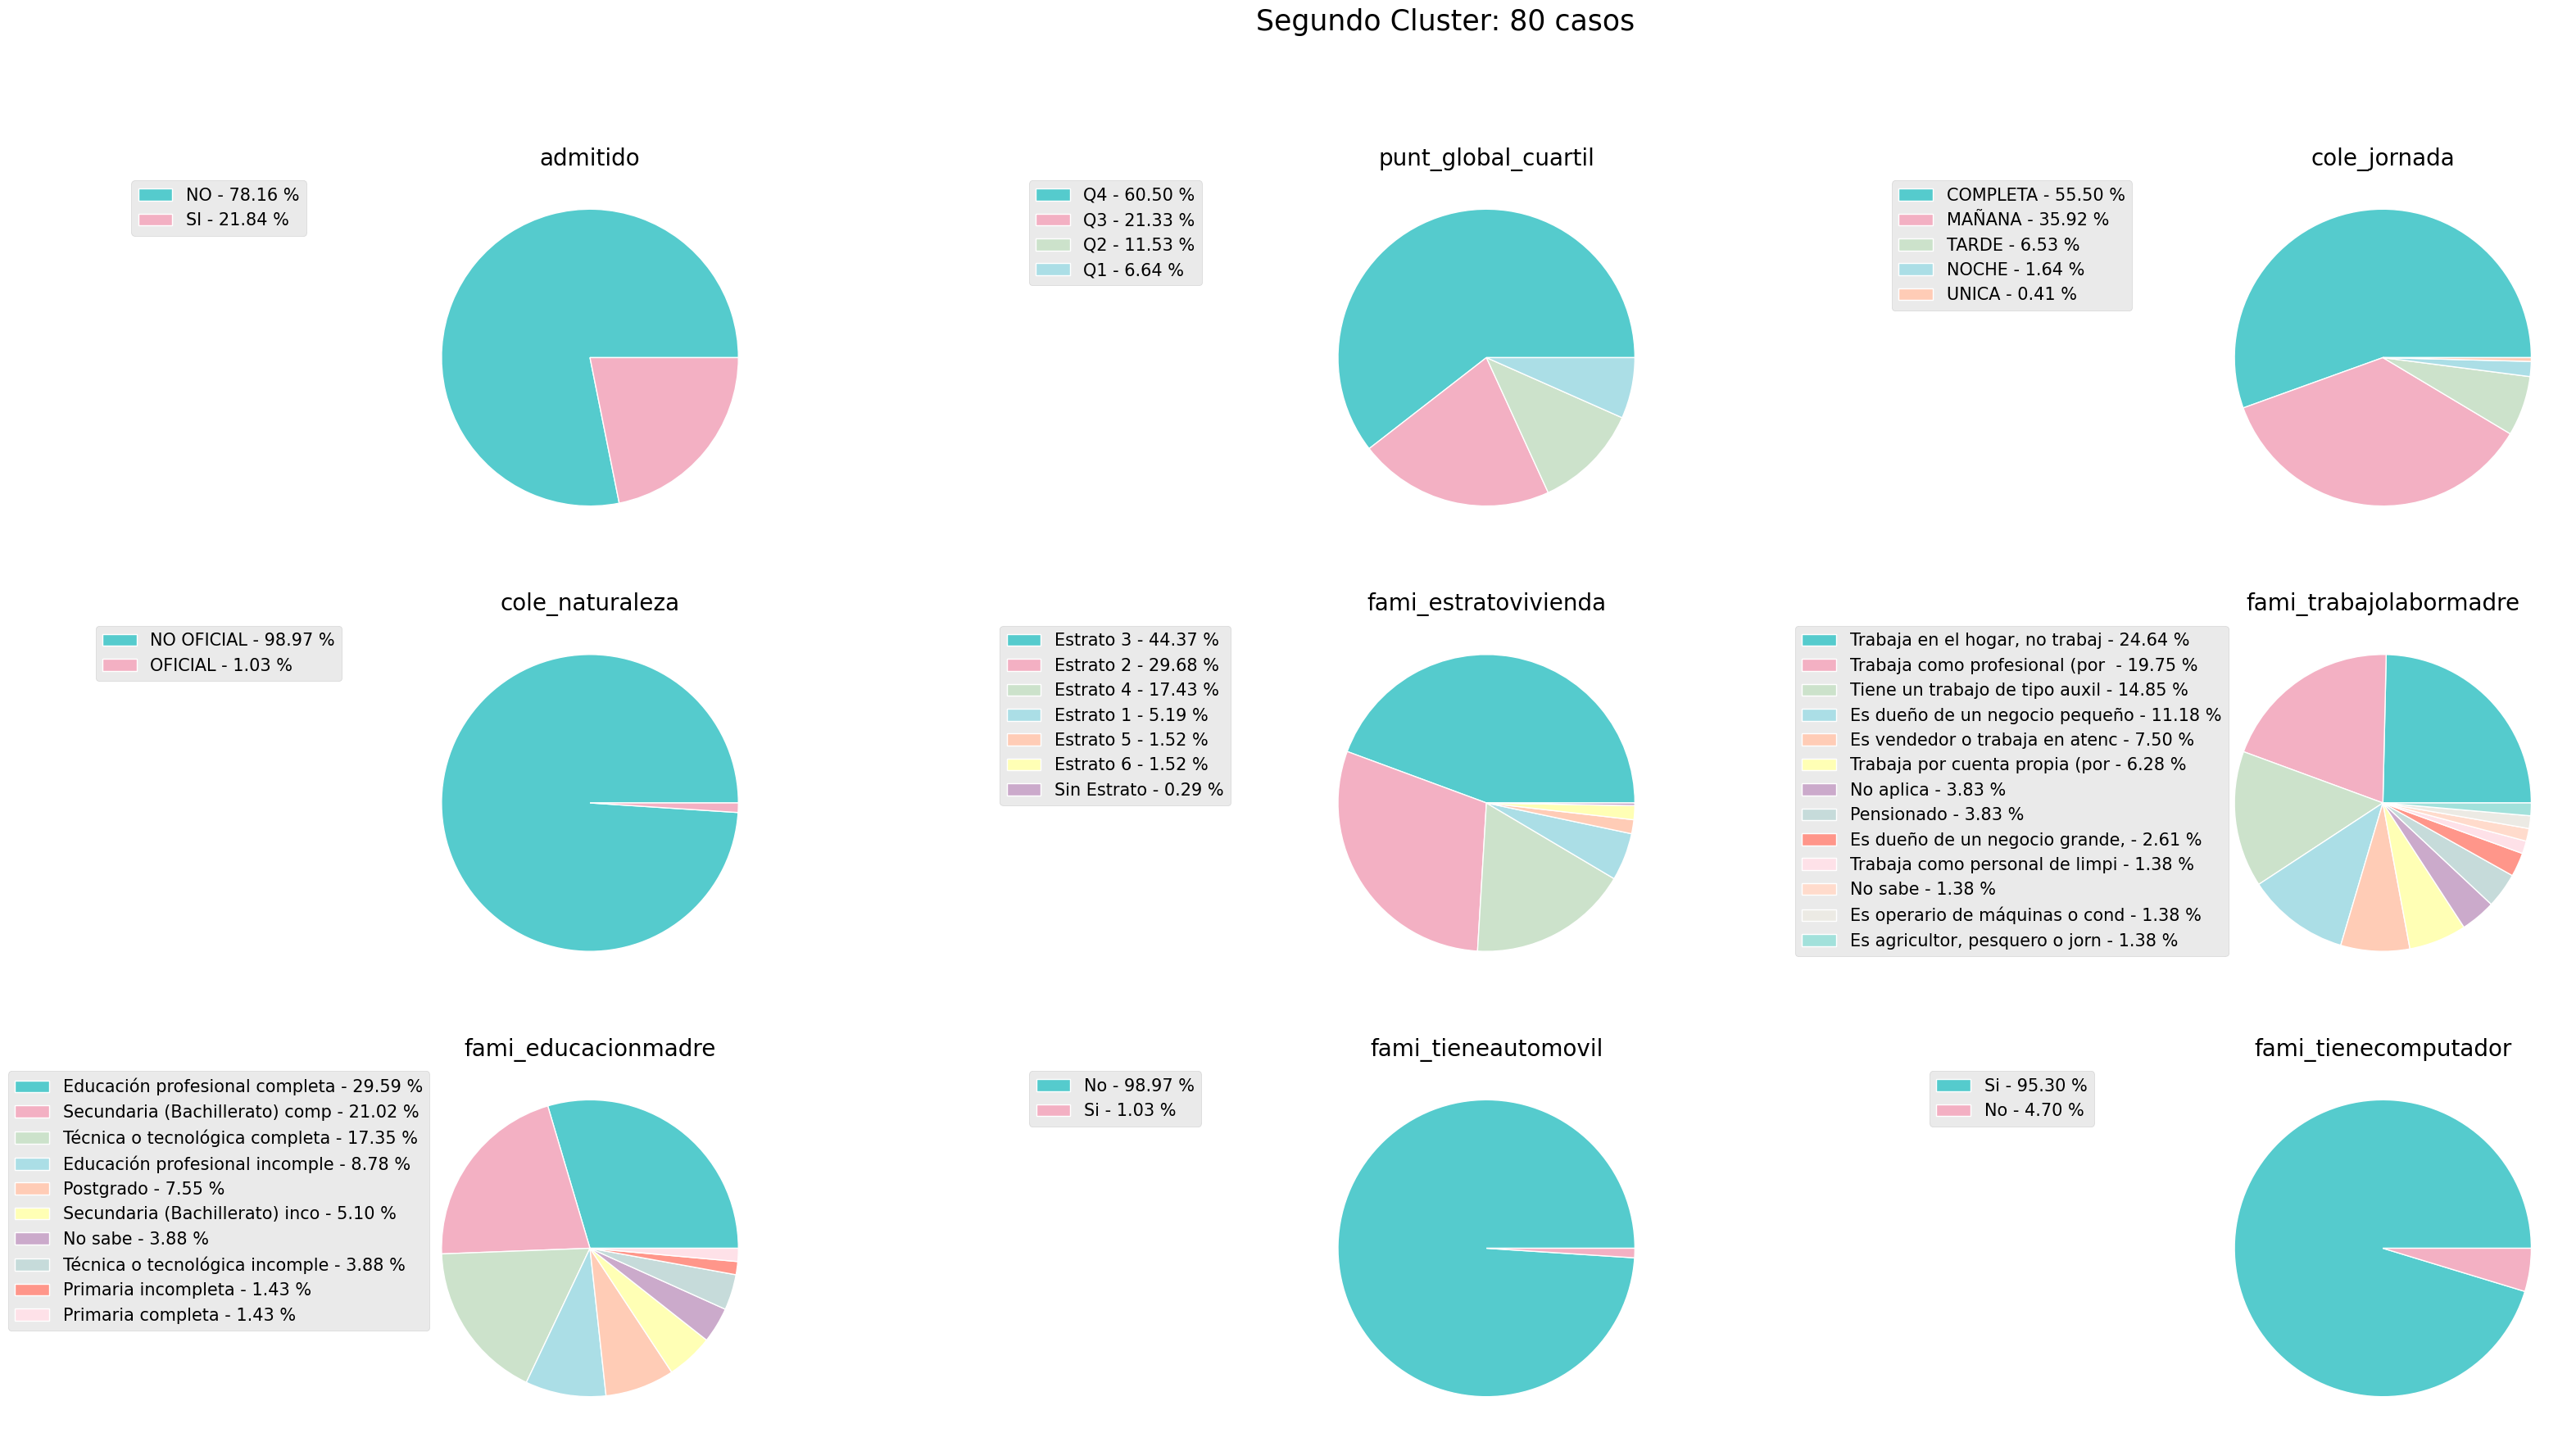

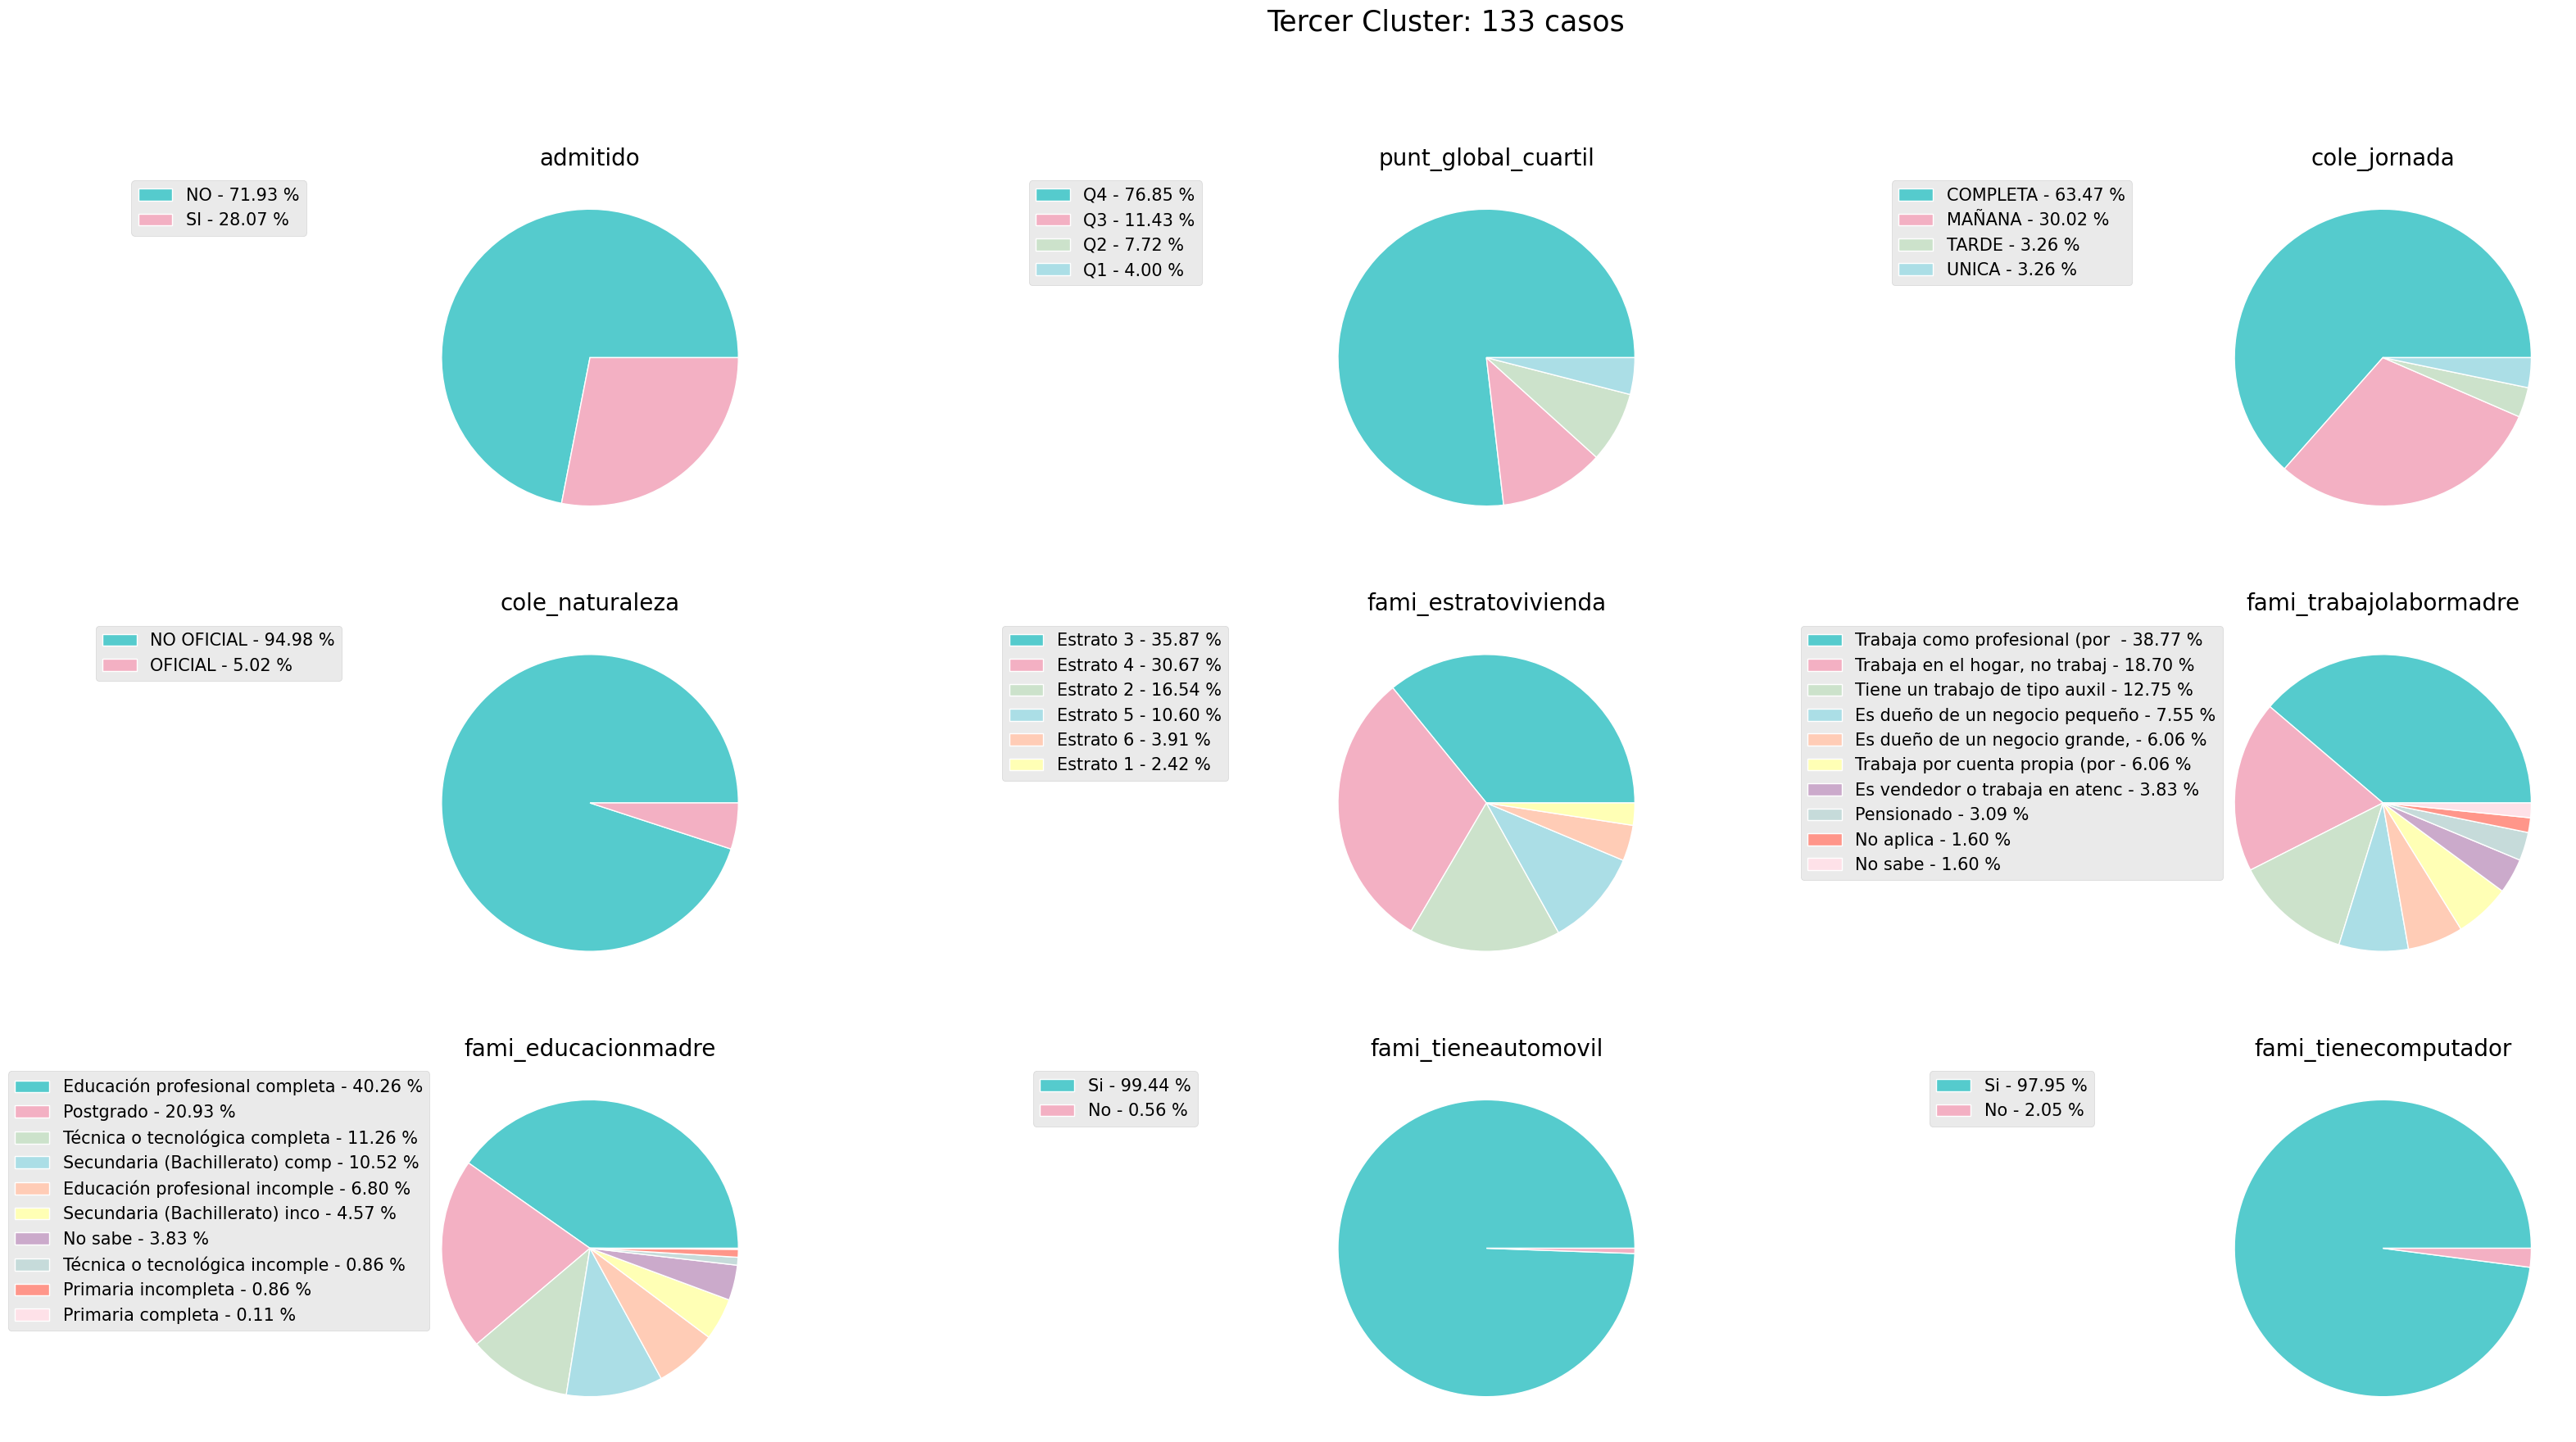

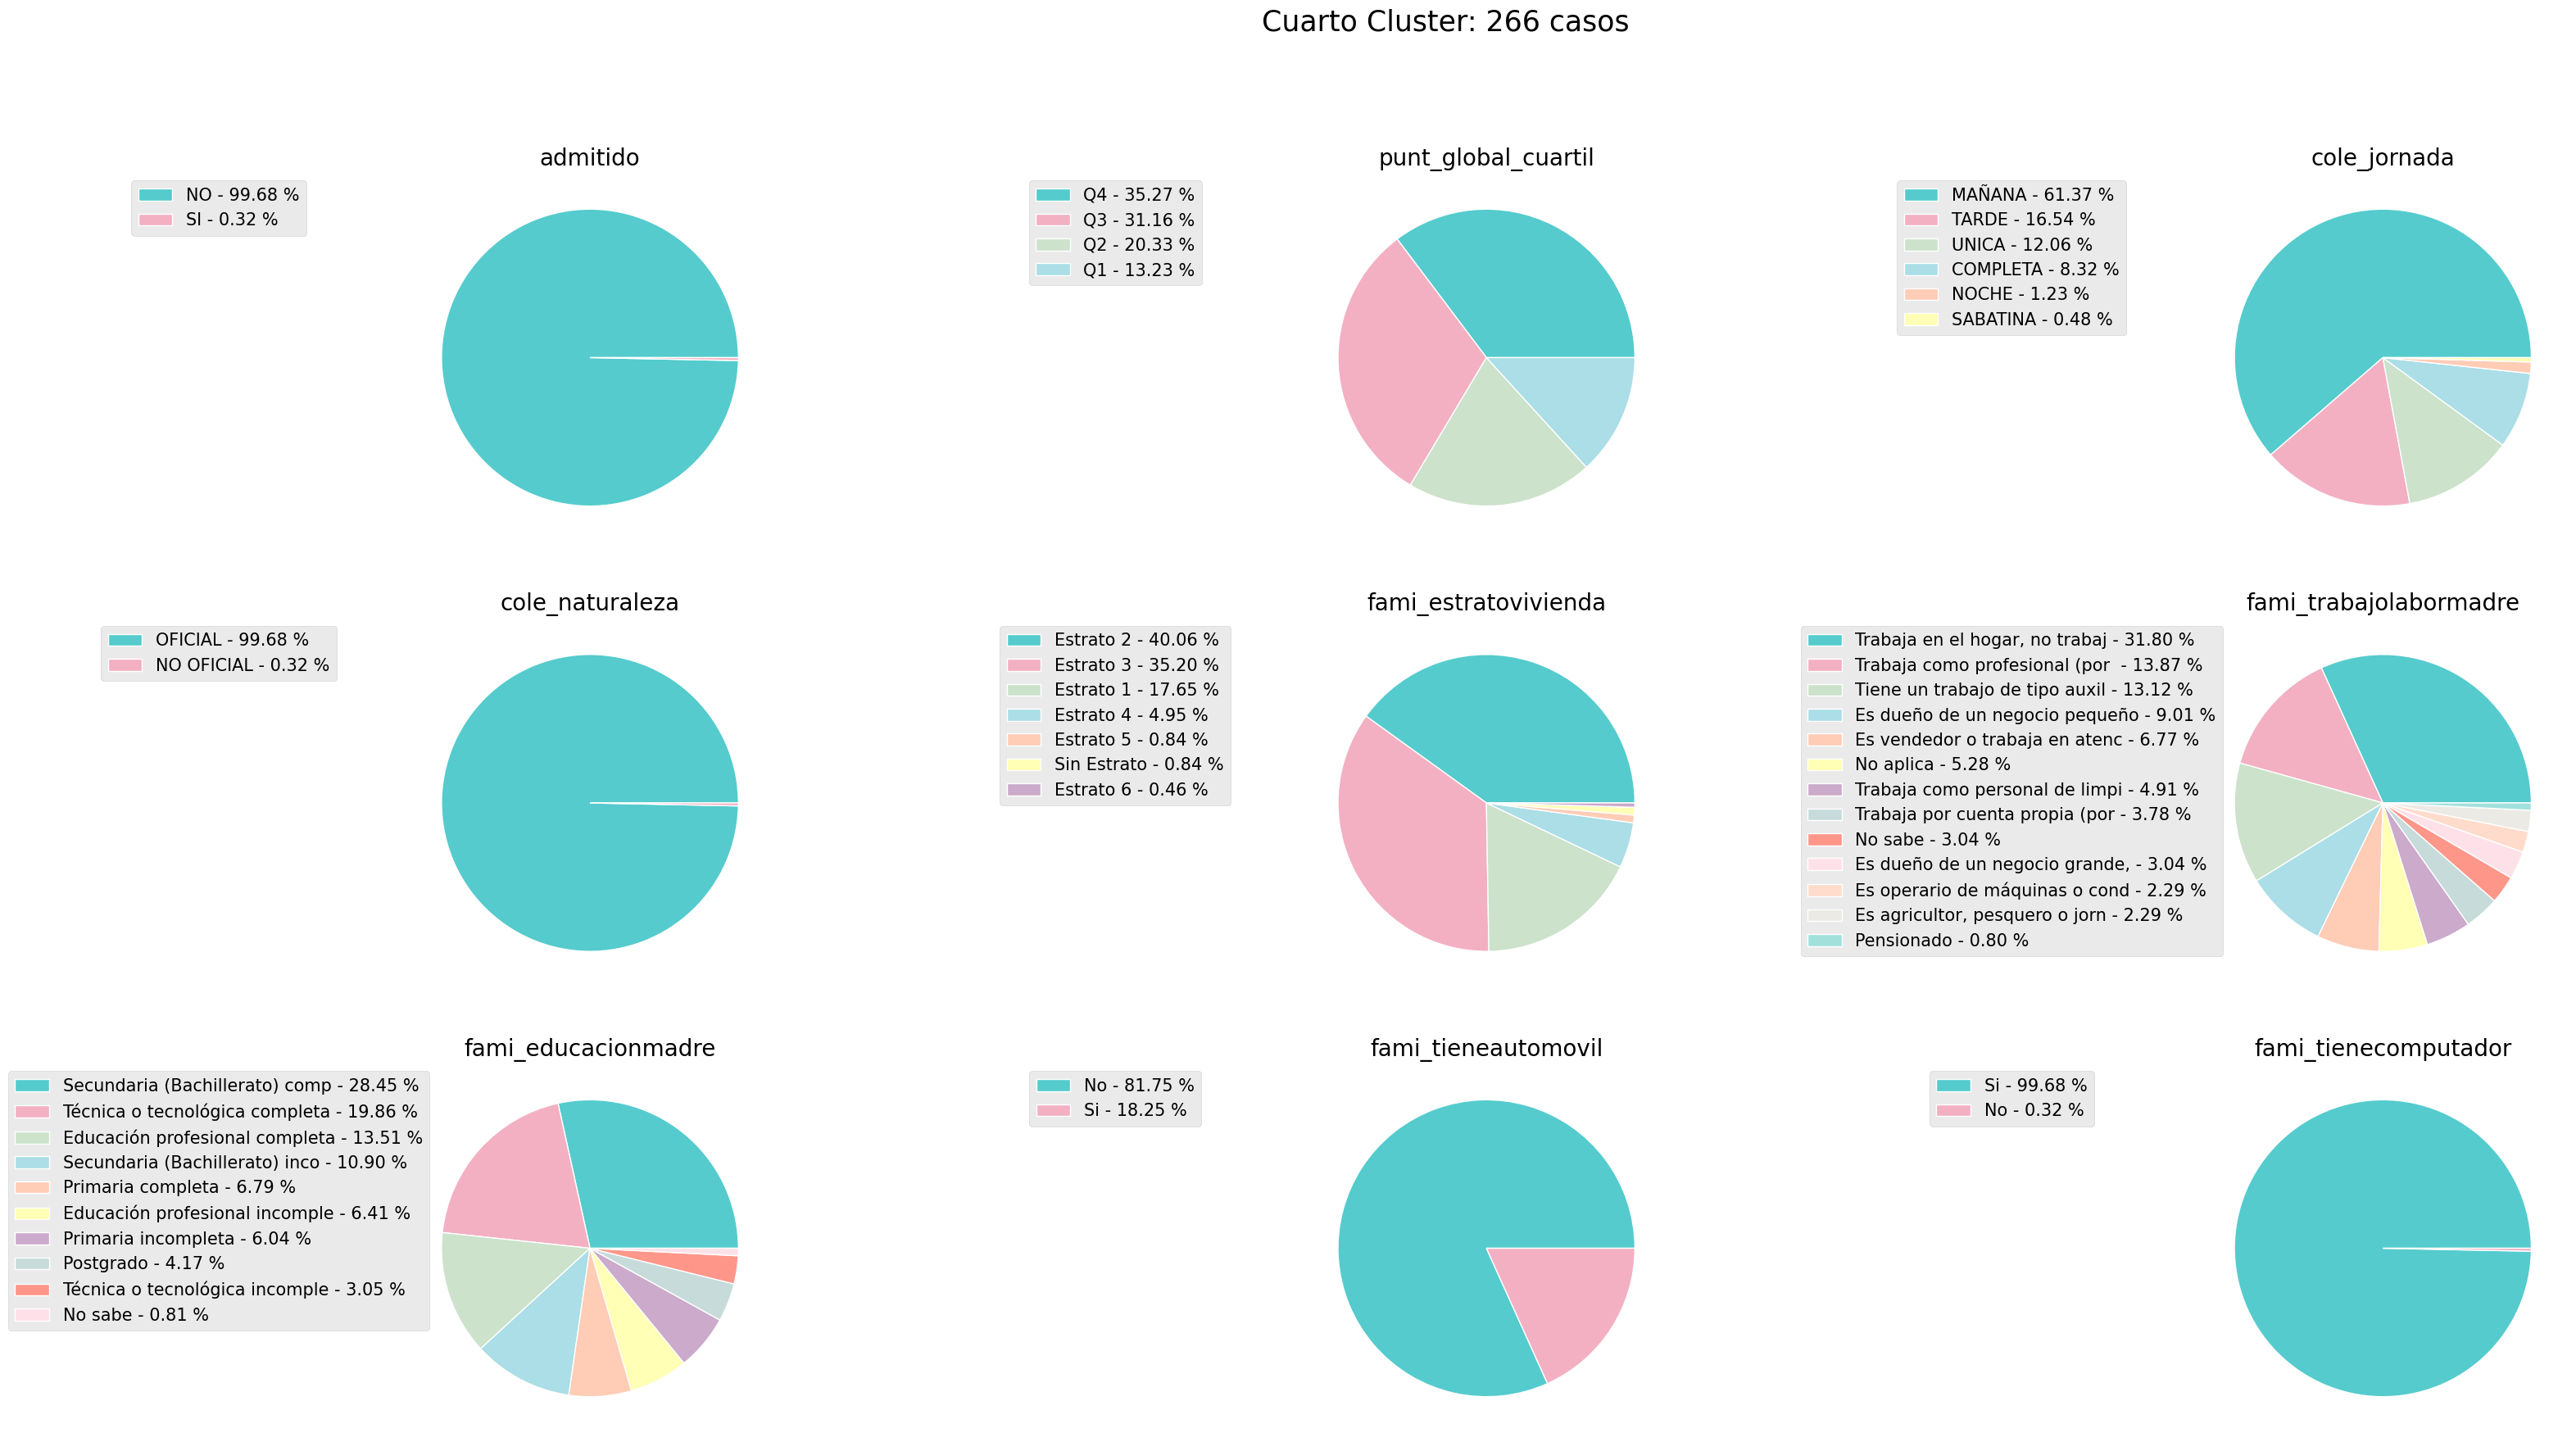

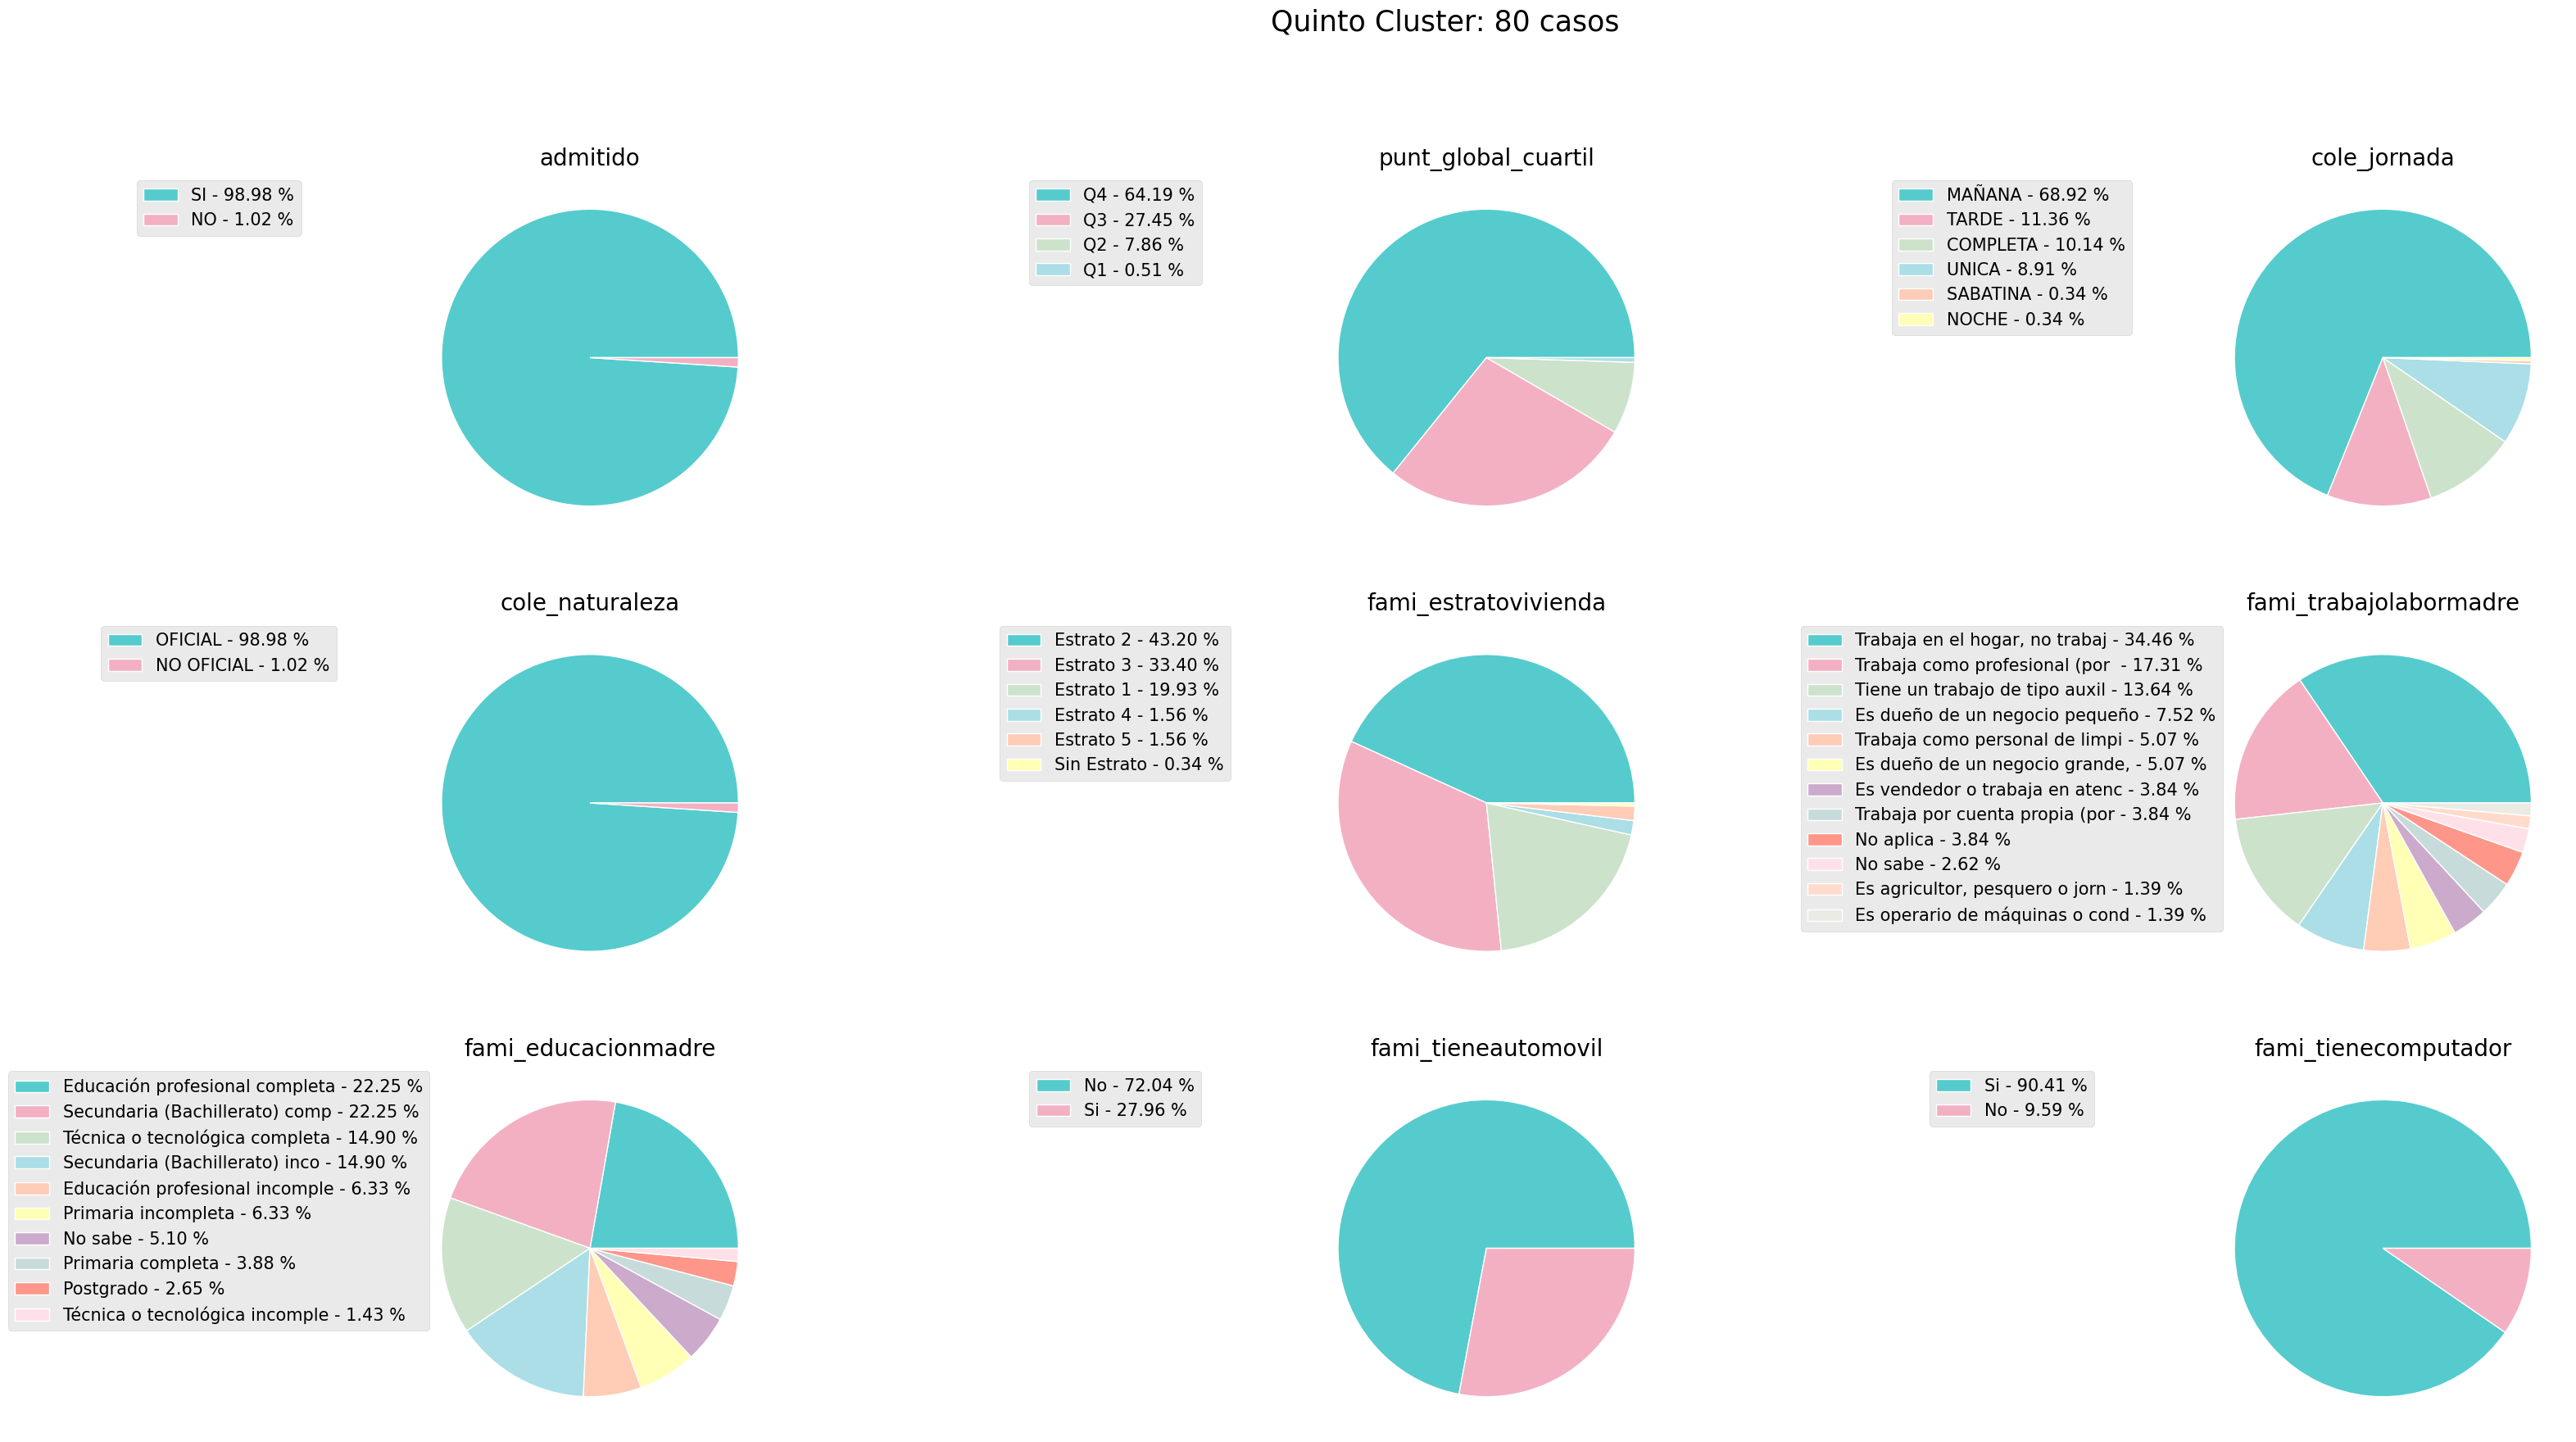

In [10]:
# Visualization of probabilistic centers through pie diagrams
df_pies = df_carrera.copy()
df_pies['cluster'] = cluster_labels_per_k[n_clusters-K_INIT]
important_attributes = list(df_centroids.index)[::-1]                 
            
clusterPies_centroids(df_centroids=df_centroids, 
                      df_data=df_pies, 
                      attributes=important_attributes, 
                      n_cols=3, 
                      figsize=(40, 20), 
                      bbox_loc=(-0.5, 1.), 
                      cat_fontsize=15,
                      pie_fontsize=20,
                      sup_fontsize=25
                     )
